In [ ]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np 
import os
import tensorflow as tf

In [ ]:
class DetectorTF2:

    def __init__(self, path_to_checkpoint, path_to_labelmap, class_id=None, threshold=0.5):
        # class_id is list of ids for desired classes, or None for all classes in the labelmap
        self.class_id = class_id
        self.Threshold = threshold
        # Loading label map
        self.category_index = self.readLabelMap(path_to_labelmap)
        tf.keras.backend.clear_session()
        start_time = time.time()
        self.detect_fn = tf.saved_model.load(path_to_checkpoint)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('Done! Took {} seconds'.format(elapsed_time))

    def DetectFromImage(self, img):
        im_height, im_width, _ = img.shape
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        input_tensor = np.expand_dims(img, 0)
        detections = self.detect_fn(input_tensor)

        bboxes = detections['detection_boxes'][0].numpy()
        bclasses = detections['detection_classes'][0].numpy().astype(np.int32)
        bscores = detections['detection_scores'][0].numpy()
        det_boxes = self.ExtractBBoxes(
            bboxes, bclasses, bscores, im_width, im_height)

        return det_boxes

    def ExtractBBoxes(self, bboxes, bclasses, bscores, im_width, im_height):
        bbox = []
        for idx in range(len(bboxes)):
            if self.class_id is None or bclasses[idx] in self.class_id:
                if bscores[idx] >= self.Threshold:
                    y_min = int(bboxes[idx][0] * im_height)
                    x_min = int(bboxes[idx][1] * im_width)
                    y_max = int(bboxes[idx][2] * im_height)
                    x_max = int(bboxes[idx][3] * im_width)
                    class_label = self.category_index[int(
                        bclasses[idx])]['name']

                    bbox.append([x_min, y_min, x_max, y_max,
                                class_label, float(bscores[idx]), idx])
        return bbox

    def writeDetectionsToImage(self, image, boxes_list, det_time=None):
        if not boxes_list:
            return image  # input list is empty
        img = image.copy()
        for idx in range(len(boxes_list)):
            x_min = boxes_list[idx][0]
            y_min = boxes_list[idx][1]
            x_max = boxes_list[idx][2]
            y_max = boxes_list[idx][3]
            cls = str(boxes_list[idx][4])
            score = str(np.round(boxes_list[idx][-1], 2))

            text = cls + ": " + score
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
            cv2.rectangle(img, (x_min, y_min - 20),
                          (x_min, y_min), (255, 255, 255), -1)
            cv2.putText(img, text, (x_min + 5, y_min - 7),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        if det_time != None:
            fps = round(1000. / det_time, 1)
            fps_txt = str(fps) + " FPS"
            cv2.putText(img, fps_txt, (25, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

        return img

    def readLabelMap(self, label_map_path):
        item_id = None
        item_name = None
        items = {}

        with open(label_map_path, "r") as file:
            for line in file:
                line.replace(" ", "")
                if line == "item{":
                    pass
                elif line == "}":
                    pass
                elif "id" in line:
                    item_id = int(line.split(":", 1)[1].strip())
                elif "name" in line:
                    item_name = line.split(":", 1)[1].replace("'", "").strip()

                if item_id is not None and item_name is not None:
                    items[item_id] = {"id": item_id, "name": item_name}
                    item_id = None
                    item_name = None

        return items

In [12]:
OBJECT_FOLDER_NAMES = ['mb_marker_buoy_black',
                       'mb_marker_buoy_green',
                       'mb_marker_buoy_red',
                       'mb_marker_buoy_white',
                       'mb_round_buoy_black',
                       'mb_round_buoy_orange',]
CAMERA_NAMES = ['front_left', 'front_right']
FOL = OBJECT_FOLDER_NAMES[4]
IMAGE_PATH = os.listdir(os.path.join(FOL, CAMERA_NAMES[0]))
IM_FOLD = os.listdir(os.path.join(
    FOL, CAMERA_NAMES[0], IMAGE_PATH[0]))


In [13]:
image = cv2.imread(os.path.join(
    FOL, CAMERA_NAMES[0], IMAGE_PATH[0], IM_FOLD[0]))


In [14]:
image.shape

(720, 1280, 3)

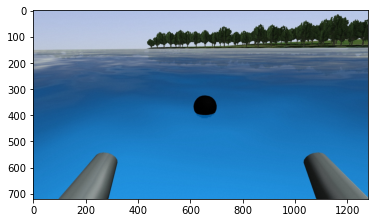

In [15]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

K-Means

In [16]:
# Reshape image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1, 3))

# Convert to float type
pixel_vals = np.float32(pixel_vals)

In [17]:
# Green
# rgb_thresh =((0,40),(40,155),(20, 110))
# Red 
# rgb_thresh = ((70, 255), (0, 20), (0, 30))
# Oranage
# rgb_thresh = ((80, 255), (10, 75), (0, 25))
# white 
rgb_thresh = ((80, 255),(80,255),(80,255))
# BLACK
# rgb_thresh = ((0, 15), (0, 15), (0, 15))


In [18]:
def orangeColorThresh(img, rgb_thresh=((130, 200), (100, 180), (0, 50))):
    """
    Returns an Image where each pixel is either a 0 or a 1 based of whether that pixel of the input
    image is below or above a certain value
    
    Args:
        img: Input Image
        rbg_thresh: pixel Thressol
        
    """
    brick_color_select = (np.where(img[:, :, 0] >= rgb_thresh[0][0], 1, 0) & np.where(img[:, :, 0] <= rgb_thresh[0][1], 1, 0)) \
        & (np.where(img[:, :, 1] >= rgb_thresh[1][0], 1, 0) & np.where(img[:, :, 1] <= rgb_thresh[1][1], 1, 0)) \
        & (np.where(img[:, :, 2] >= rgb_thresh[2][0], 1, 0) & np.where(img[:, :, 2] <= rgb_thresh[2][1], 1, 0))
    # Return the binary image
    return brick_color_select


def colorThresh(img, rgb_thresh=((130, 200), (100, 180), (0, 50))):
    """
    Returns an Image where each pixel is either a 0 or a 1 based of whether that pixel of the input
    image is below or above a certain value
    
    Args:
        img: Input Image
        rbg_thresh: pixel Thressol
        
    """
    brick_color_select = (np.where(img[:, :, 0] > rgb_thresh[0][0], 1, 0) & np.where(img[:, :, 0] < rgb_thresh[0][1], 1, 0)) \
        & (np.where(img[:, :, 1] > rgb_thresh[1][0], 1, 0) & np.where(img[:, :, 1] < rgb_thresh[1][1], 1, 0)) \
        & (np.where(img[:, :, 2] >= rgb_thresh[2][0], 1, 0) & np.where(img[:, :, 2] < rgb_thresh[2][1], 1, 0))
    # Return the binary image
    return brick_color_select


In [19]:
# def colorThresh(img, rgb_thresh=((130, 200), (100, 180), (0, 50))):
#     """
#     Returns an Image where each pixel is either a 0 or a 1 based of whether that pixel of the input
#     image is below or above a certain value
    
#     Args:
#         img: Input Image
#         rbg_thresh: pixel Thressol
        
#     """
#     brick_color_select = (np.where(img[:, :, 0] >= rgb_thresh[0][0], 1, 0) & np.where(img[:, :, 0] <= rgb_thresh[0][1], 1, 0)) \
#         & (np.where(img[:, :, 1] >= rgb_thresh[1][0], 1, 0) & np.where(img[:, :, 1] <= rgb_thresh[1][1], 1, 0)) \
#         & (np.where(img[:, :, 2] >= rgb_thresh[2][0], 1, 0) & np.where(img[:, :, 2] <= rgb_thresh[2][1], 1, 0))
#     # Return the binary image
#     return brick_color_select


The color selection of the brick


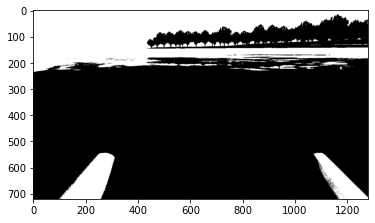

In [20]:
print("The color selection of the brick")
tmp1 = orangeColorThresh(cv2.cvtColor(
    image, cv2.COLOR_BGR2RGB), rgb_thresh=rgb_thresh)
plt.imshow(tmp1, cmap='gray')


In [21]:
max(tmp1.ravel().astype(np.uint8)*255)

255

In [22]:
isinstance(None, type(None))

True

In [23]:
try:
    os.remove("demofile.txt")
except:
    print("Hi")


Hi


In [24]:
IM_FOLD[0]


'008f04e4-cead-4d9b-a3fb-57559be5e79d.jpg'

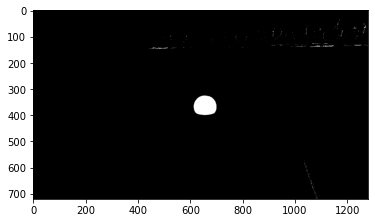

In [32]:
image = cv2.imread(os.path.join(
    FOL, CAMERA_NAMES[0], IMAGE_PATH[0], IM_FOLD[0]))


# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create a binary thresholded image
retval, threshold = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY_INV)

plt.imshow(threshold, cmap='gray')


In [28]:
threshold


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# Find contours from thresholded, binary imag
contours, hierarchy = cv2.findContours(
    binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on a copy of the original image
contours_image = np.copy(image)
cnt = contours[1]
# contours_image = cv2.drawContours(contours_image, contours, -1, (0,255,0), 3)
contours_image = cv2.drawContours(contours_image, contours, -1, (0, 255, 0), 3)

plt.imshow(contours_image)


threshold = colorThresh(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                        rgb_thresh=rgb_thresh)
threshold.astype(np.uint8)


In [17]:
def centerCrop(img, w, h):
    center = np.array(image.shape) / 2
    x = center[1] - w/2
    y = center[0] - h/2

    crop_img = img[int(y):int(y+h), int(x):int(x+w)]
    return crop_img


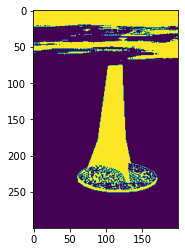

In [33]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
  
image = cv2.imread(os.path.join(
    FOL, CAMERA_NAMES[0], IMAGE_PATH[0], IM_FOLD[40]))

# reading image
# img = cv2.imread('shapes.png')
img = np.copy(image)
crop_x =200
crop_y = 300
img1 = centerCrop(np.copy(img), crop_x, crop_y)
  
# converting image into grayscale image
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
threshold = colorThresh(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB),
                   rgb_thresh=rgb_thresh)

plt.imshow(threshold)
# setting threshold of gray image
# _, threshold = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
  
# using a findContours() function
contours, _ = cv2.findContours(
    threshold.astype(np.uint8)*255, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
  
i = 0

contour_areas = []
max_contour_area = 0
max_area_contour = None
max_height_contour = None
max_height = 0
rect_dims = []
  
# list for storing names of shapes
for contour in contours:
  
    # here we are ignoring first counter because 
    #indcontour function detects whole image as shape
    # if i == 0:
    #     i = 1
    #     continue
  
    # cv2.approxPloyDP() function to approximate the shape
    approx = cv2.approxPolyDP(
        contour, 0.01 * cv2.arcLength(contour, True), True)
      
    # using drawContours() function
    # cv2.drawContours(img1, [contour], 0, (0, 0, 255), 5)
    contour_areas.append(cv2.contourArea(contour))
    # finding center point of shape
    x, y, w, h = cv2.boundingRect(contour)
    rect_dims.append((x,y,w,h))
    if(cv2.contourArea(contour)> max_contour_area):
        max_contour_area = cv2.contourArea(contour)
        max_area_contour = contour
        
    if(h> max_height):
        max_height = h
        max_height_contour = contour
        
        
    # M = cv2.moments(contour)
    # if M['m00'] != 0.0:
    #     x = int(M['m10']/M['m00'])
    #     y = int(M['m01']/M['m00'])
    #     print(len(approx))
    #     if len(approx) <= 6:
    #         pass
    #         # cv2.putText(img, 'Hexagon', (x, y),
    #                     # cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    #     elif 6<len(approx) <24:
    #         pass    
    #     else:
    #         cv2.putText(img, 'circle', (x, y),
    #                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
x, y, w, h = cv2.boundingRect(max_height_contour)
# cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 5)
cv2.rectangle(img, 
              (,
               int(y + (img.shape[0]/2) - crop_y/2)),
              (int(x+w +(img.shape[1]/2) - crop_x/2),
               int(img.shape[0]/2 - crop_y/2 + y+h)),
              (0, 0, 255), 5)

# cv2.drawContours(img, [contours[6]], 0, (0, 0, 255), 5)

  

# displaying the image after drawing contoursq
cv2.imshow('shapes', img)
  
cv2.waitKey(0)
cv2.destroyAllWindows()


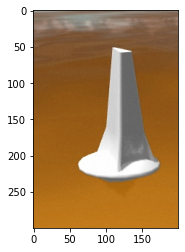

In [50]:
plt.imshow(centerCrop(image, 200, 300))

In [29]:
np.argmin(match_score)

893

In [ ]:
cv2.imshow('shapes', img)
  
cv2.waitKey(0)
cv2.destroyAllWindows()


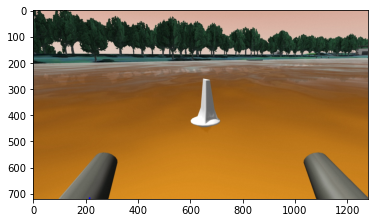

In [40]:
img1 = np.copy(image)
img2 = cv2.drawContours(img1, [contours[np.argmax(match_score)]], 0, (0, 0, 255), 5)
# img2 = cv2.drawContours(
    # img1, [contour_template], 0, (0, 0, 255), 5)

# ret = cv2.matchShapes(cnt1, cnt2, 1, 0.0)
plt.imshow(img2)


In [27]:
np.save("pickle_files/bouy_marker_template", contours[6])


In [22]:
contour_areas


[0.0,
 0.0,
 0.0,
 0.0,
 919601.0,
 2.0,
 9834.5,
 2.0,
 4.0,
 4.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 14.0,
 5.5,
 2.0,
 16.5,
 2.0,
 2.0,
 2.0,
 2.0,
 111.0,
 2.0,
 2.0,
 2.0,
 2.0]

In [45]:
len(contours)

1

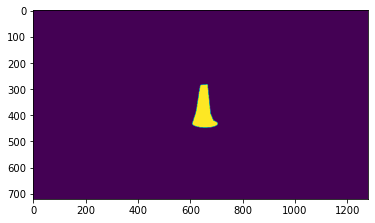

In [36]:
plt.imshow(threshold)